# First I need to load the data to start the preprocessing step

In [1]:
from google.colab import files
import pandas as pd
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d rikdifos/credit-card-approval-prediction
!unzip credit-card-approval-prediction.zip
table1 = pd.read_csv('application_record.csv')
table2 = pd.read_csv('credit_record.csv')
print("Table 1:")
print(table1.head())
print("\nTable 2:")
print(table2.head())

Saving kaggle.json to kaggle.json
ref                                                           title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
muhammadroshaanriaz/students-performance-dataset-cleaned      Students Performance | Clean Dataset                10KB  2024-10-29 19:32:26           7068        136  1.0              
ravindrasinghrana/carbon-co2-emissions                        Carbon (CO2) Emissions                              42KB  2024-10-28 09:11:56           1985         29  1.0              
positivealexey/youtube-channel-performance-analytics          YouTube Channel Performance Analytics               40KB  2024-10-25 10:06:26           1858         30  1.0              
steve1215rogg/student-lifestyle-dataset  

# We need now to define the criteria we will be working on , I will consider delays as weights as in the code below , then I will only consider the last 12 months as they are more relevant for our consideration. Then I will take a threshold score as avg thresholds of all the users to balance the dataset we have and if the person's score is less than threshold he will be labeled as good

In [2]:
status_weights = {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '0': 0.5, 'C': 0, 'X': 0}
table2['weighted_status'] = table2['STATUS'].map(status_weights)
client_weights = table2.groupby('ID')['weighted_status'].sum()
avg_threshold = client_weights.mean()
print(f"Average threshold across all clients: {avg_threshold:.2f}")
def weighted_temporal_label(status_list, months_to_consider=12, threshold=avg_threshold):
    recent_statuses = status_list[-months_to_consider:] if len(status_list) > months_to_consider else status_list
    weighted_score = sum(status_weights.get(status, 0) for status in recent_statuses)
    return 'Bad' if weighted_score > threshold else 'Good'
client_labels = table2.groupby('ID')['STATUS'].apply(list).apply(weighted_temporal_label).reset_index()
client_labels.rename(columns={'STATUS': 'Loan_Status'}, inplace=True)
merged_table = pd.merge(table1, client_labels, on='ID', how='left')
class_counts = merged_table['Loan_Status'].value_counts()
print("Counts of each class after combined criteria:")
print(class_counts)

Average threshold across all clients: 4.67
Counts of each class after combined criteria:
Loan_Status
Good    25344
Bad     11113
Name: count, dtype: int64


# I first chose this criteria : (0,c,x,1) = good , and else is bad , and if a person has more than one bad he is considered bad totally , but after doing the machine learning model I figured out that the data is too biased with less data in the bad side and a lot of data good side , so I figured out the new criteria to make it less biased
this was the outcome of the first criteria
Accuracy: 0.9912232583653319

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.99      1.00      1.00      7228

    accuracy                           0.99      7292
   macro avg       0.50      0.50      0.50      7292
weighted avg       0.98      0.99      0.99      7292


Confusion Matrix:
 [[   0   64]
 [   0 7228]]
# which says that it predicts all the good but no bad , which means the model is too biased , that's why I had to change it to the previous criteria

<ipython-input-4-329e4738c2a8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Loan_Status', data=merged_table, palette='Set2')


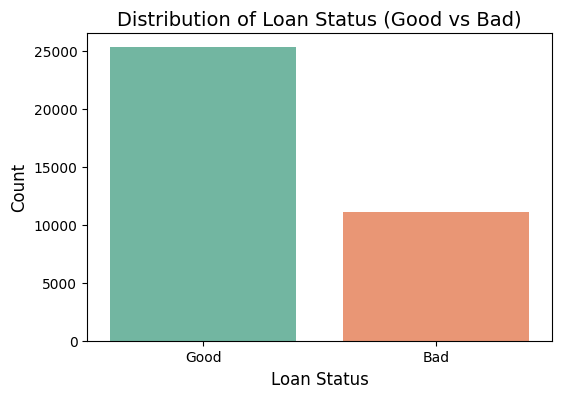

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
class_counts = merged_table['Loan_Status'].value_counts()
plt.figure(figsize=(6, 4))
sns.countplot(x='Loan_Status', data=merged_table, palette='Set2')
plt.title('Distribution of Loan Status (Good vs Bad)', fontsize=14)
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [5]:
missing_data = merged_table.isnull().sum()
print(missing_data)

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
Loan_Status            402100
dtype: int64


In [6]:
print(merged_table['OCCUPATION_TYPE'].value_counts())

OCCUPATION_TYPE
Laborers                 78240
Core staff               43007
Sales staff              41098
Managers                 35487
Drivers                  26090
High skill tech staff    17289
Accountants              15985
Medicine staff           13520
Cooking staff             8076
Security staff            7993
Cleaning staff            5845
Private service staff     3456
Low-skill Laborers        2140
Secretaries               2044
Waiters/barmen staff      1665
Realty agents             1041
HR staff                   774
IT staff                   604
Name: count, dtype: int64


# Given the current status of missing data, I would choose to fill the missing values of occupation type with Unknown, as giving them the mode of the column data wouldn't be accurate in my opinion.

In [7]:
merged_table['OCCUPATION_TYPE'] = merged_table['OCCUPATION_TYPE'].fillna('Unknown')

In [8]:
missing_data = merged_table.isnull().sum()
print(missing_data)

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE             0
CNT_FAM_MEMBERS             0
Loan_Status            402100
dtype: int64


In [9]:
missing_loan_status = merged_table[merged_table['Loan_Status'].isnull()]
non_missing_loan_status = merged_table[merged_table['Loan_Status'].notnull()]
print(f"Data with missing Loan_Status: {missing_loan_status.shape}")
print(f"Data with non-missing Loan_Status: {non_missing_loan_status.shape}")
print('missing values -> {}'.format(non_missing_loan_status.isna().sum().sum()))
print('duplicate values -> {}'.format(non_missing_loan_status.duplicated().sum()))
print(non_missing_loan_status.columns)
non_missing_loan_status.head()


Data with missing Loan_Status: (402100, 19)
Data with non-missing Loan_Status: (36457, 19)
missing values -> 0
duplicate values -> 0
Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'Loan_Status'],
      dtype='object')


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Loan_Status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Unknown,2.0,Good
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Unknown,2.0,Good
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,Good
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,Good
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,Good


In [10]:
non_missing_loan_status.nunique()

,0
ID,36457
CODE_GENDER,2
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
CNT_CHILDREN,9
AMT_INCOME_TOTAL,265
NAME_INCOME_TYPE,5
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,5
NAME_HOUSING_TYPE,6


# Flag_mobil is not important in our model so I will drop it

In [11]:
non_missing_loan_status.drop('FLAG_MOBIL', axis=1, inplace=True)
duplicate_ids = non_missing_loan_status[non_missing_loan_status.duplicated(subset='ID')]

print(f"Number of duplicate IDs: {duplicate_ids.shape[0]}")
print(non_missing_loan_status.head)

Number of duplicate IDs: 0
<bound method NDFrame.head of              ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804           M            Y               Y             0   
1       5008805           M            Y               Y             0   
2       5008806           M            Y               Y             0   
3       5008808           F            N               Y             0   
4       5008809           F            N               Y             0   
...         ...         ...          ...             ...           ...   
434808  5149828           M            Y               Y             0   
434809  5149834           F            N               Y             0   
434810  5149838           F            N               Y             0   
434811  5150049           F            N               Y             0   
434812  5150337           M            N               Y             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE        

<ipython-input-11-dca191d01f00>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_missing_loan_status.drop('FLAG_MOBIL', axis=1, inplace=True)


# Now handling the encoding
Applying the following techniques:
Scaling for values that are numerical like income , birth , employement
doing one hot encoding for categorical columns
mapping loan statusto 1 and 0

In [12]:
non_missing_loan_status.loc[:, 'AGE_YEARS'] = -non_missing_loan_status['DAYS_BIRTH'] / 365.2425
non_missing_loan_status.drop('DAYS_BIRTH', axis=1, inplace=True)
non_missing_loan_status.loc[:, 'UNEMPLOYED'] = 0
non_missing_loan_status.loc[-non_missing_loan_status['DAYS_EMPLOYED'] < 0, 'UNEMPLOYED'] = 1
non_missing_loan_status.loc[:, 'YEARS_EMPLOYED'] = -non_missing_loan_status['DAYS_EMPLOYED'] / 365.2425
non_missing_loan_status.loc[non_missing_loan_status['YEARS_EMPLOYED'] < 0, 'YEARS_EMPLOYED'] = 0
non_missing_loan_status.drop('DAYS_EMPLOYED', axis=1, inplace=True)
binary_columns = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
for col in binary_columns:
    non_missing_loan_status.loc[:, col] = non_missing_loan_status[col].map({'Y': 1, 'N': 0, True: 1, False: 0})
non_missing_loan_status.loc[:, 'CODE_GENDER'] = non_missing_loan_status['CODE_GENDER'].map({'M': 1, 'F': 0}).fillna(-1)
non_missing_loan_status.loc[:, 'Loan_Status'] = non_missing_loan_status['Loan_Status'].map({'Good': 1, 'Bad': 0})
non_missing_loan_status = non_missing_loan_status.rename(columns={
    'CODE_GENDER': 'Gender',
    'FLAG_OWN_CAR': 'Own_car',
    'FLAG_OWN_REALTY': 'Own_property',
    'CNT_CHILDREN': 'Num_children',
    'AMT_INCOME_TOTAL': 'Total_income',
    'NAME_INCOME_TYPE': 'Income_type',
    'NAME_EDUCATION_TYPE': 'Education_type',
    'NAME_FAMILY_STATUS': 'Family_status',
    'NAME_HOUSING_TYPE': 'Housing_type',
    'FLAG_WORK_PHONE': 'Work_phone',
    'FLAG_PHONE': 'Phone',
    'FLAG_EMAIL': 'Email',
    'OCCUPATION_TYPE': 'Occupation_type',
    'CNT_FAM_MEMBERS': 'Num_family',
    'ACCOUNT_LENGTH': 'Account_length',
    'AGE_YEARS': 'Age',
    'UNEMPLOYED': 'Unemployed',
    'YEARS_EMPLOYED': 'Years_employed'
})
non_missing_loan_status.head()


<ipython-input-12-64acca546267>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_missing_loan_status.loc[:, 'AGE_YEARS'] = -non_missing_loan_status['DAYS_BIRTH'] / 365.2425
<ipython-input-12-64acca546267>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_missing_loan_status.drop('DAYS_BIRTH', axis=1, inplace=True)
<ipython-input-12-64acca546267>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

,ID,Gender,Own_car,Own_property,Num_children,Total_income,Income_type,Education_type,Family_status,Housing_type,Work_phone,Phone,Email,Occupation_type,Num_family,Loan_Status,Age,Unemployed,Years_employed
0,5008804,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Unknown,2.0,1,32.868574,0,12.435574
1,5008805,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Unknown,2.0,1,32.868574,0,12.435574
2,5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,1,58.793815,0,3.104787
3,5008808,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,1,52.321403,0,8.353354
4,5008809,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,1,52.321403,0,8.353354


In [13]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
non_missing_loan_status['Total_income'] = scaler.fit_transform(non_missing_loan_status[['Total_income']])
non_missing_loan_status = pd.get_dummies(non_missing_loan_status,
                                         columns=['Income_type', 'Education_type', 'Family_status', 'Housing_type'],
                                         drop_first=True)
non_missing_loan_status = non_missing_loan_status.astype({col: int for col in non_missing_loan_status.select_dtypes('bool').columns})
le = LabelEncoder()
non_missing_loan_status['Occupation_type'] = le.fit_transform(non_missing_loan_status['Occupation_type'])
print(non_missing_loan_status.head())


        ID Gender Own_car Own_property  Num_children  Total_income  \
0  5008804      1       1            1             0      2.365845   
1  5008805      1       1            1             0      2.365845   
2  5008806      1       1            1             0     -0.728827   
3  5008808      0       0            1             0      0.818509   
4  5008809      0       0            1             0      0.818509   

   Work_phone  Phone  Email  Occupation_type  ...  \
0           1      0      0               17  ...   
1           1      0      0               17  ...   
2           0      0      0               16  ...   
3           0      1      1               14  ...   
4           0      1      1               14  ...   

   Education_type_Secondary / secondary special Family_status_Married  \
0                                             0                     0   
1                                             0                     0   
2                                        

In [14]:
non_missing_loan_status.head(10)
pd.set_option('display.max_columns', None)
non_missing_loan_status.head()

,ID,Gender,Own_car,Own_property,Num_children,Total_income,Work_phone,Phone,Email,Occupation_type,Num_family,Loan_Status,Age,Unemployed,Years_employed,Income_type_Pensioner,Income_type_State servant,Income_type_Student,Income_type_Working,Education_type_Higher education,Education_type_Incomplete higher,Education_type_Lower secondary,Education_type_Secondary / secondary special,Family_status_Married,Family_status_Separated,Family_status_Single / not married,Family_status_Widow,Housing_type_House / apartment,Housing_type_Municipal apartment,Housing_type_Office apartment,Housing_type_Rented apartment,Housing_type_With parents
0,5008804,1,1,1,0,2.365845,1,0,0,17,2.0,1,32.868574,0,12.435574,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
1,5008805,1,1,1,0,2.365845,1,0,0,17,2.0,1,32.868574,0,12.435574,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
2,5008806,1,1,1,0,-0.728827,0,0,0,16,2.0,1,58.793815,0,3.104787,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0
3,5008808,0,0,1,0,0.818509,0,1,1,14,1.0,1,52.321403,0,8.353354,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
4,5008809,0,0,1,0,0.818509,0,1,1,14,1.0,1,52.321403,0,8.353354,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0


In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical_features = ['Total_income', 'Years_employed', 'Age']
non_missing_loan_status[numerical_features] = scaler.fit_transform(non_missing_loan_status[numerical_features])


In [16]:
non_missing_loan_status.head(10)
pd.set_option('display.max_columns', None)
non_missing_loan_status.head()

,ID,Gender,Own_car,Own_property,Num_children,Total_income,Work_phone,Phone,Email,Occupation_type,Num_family,Loan_Status,Age,Unemployed,Years_employed,Income_type_Pensioner,Income_type_State servant,Income_type_Student,Income_type_Working,Education_type_Higher education,Education_type_Incomplete higher,Education_type_Lower secondary,Education_type_Secondary / secondary special,Family_status_Married,Family_status_Separated,Family_status_Single / not married,Family_status_Widow,Housing_type_House / apartment,Housing_type_Municipal apartment,Housing_type_Office apartment,Housing_type_Rented apartment,Housing_type_With parents
0,5008804,1,1,1,0,0.258721,1,0,0,17,2.0,1,0.255676,0,0.28906,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
1,5008805,1,1,1,0,0.258721,1,0,0,17,2.0,1,0.255676,0,0.28906,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
2,5008806,1,1,1,0,0.055233,0,0,0,16,2.0,1,0.791768,0,0.07217,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0
3,5008808,0,0,1,0,0.156977,0,1,1,14,1.0,1,0.657929,0,0.19417,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
4,5008809,0,0,1,0,0.156977,0,1,1,14,1.0,1,0.657929,0,0.19417,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0


# Checking anomalies


In [17]:
false_entries_count = (non_missing_loan_status['Years_employed'] > non_missing_loan_status['Age']).sum()
print(f"Number of false entries: {false_entries_count}")


Number of false entries: 2997


In [18]:
problematic_rows = non_missing_loan_status[non_missing_loan_status['Years_employed'] > non_missing_loan_status['Age']]
print(problematic_rows[['Years_employed', 'Age']])
non_missing_loan_status.loc[non_missing_loan_status['Years_employed'] > non_missing_loan_status['Age'], 'Years_employed'] = None
print(non_missing_loan_status[['Years_employed', 'Age']].describe())
false_entries_count = (non_missing_loan_status['Years_employed'] > non_missing_loan_status['Age']).sum()
print(f"Number of false entries: {false_entries_count}")


        Years_employed       Age
0             0.289060  0.255676
1             0.289060  0.255676
144           0.178706  0.160335
145           0.178706  0.160335
146           0.178706  0.160335
...                ...       ...
434731        0.480685  0.427900
434750        0.174696  0.166223
434803        0.227646  0.196060
434804        0.227646  0.196060
434807        0.597658  0.489611

[2997 rows x 2 columns]
       Years_employed           Age
count    33460.000000  36457.000000
mean         0.120188      0.480449
std          0.126067      0.237816
min          0.000000      0.000000
25%          0.020174      0.281549
50%          0.086489      0.457114
75%          0.178706      0.676499
max          0.853752      1.000000
Number of false entries: 0


In [20]:
median_years = non_missing_loan_status['Years_employed'].median()
non_missing_loan_status['Years_employed'].fillna(median_years, inplace=True)
false_entries_count = (non_missing_loan_status['Years_employed'] > non_missing_loan_status['Age']).sum()

print(f"Number of false entries: {false_entries_count}")

Number of false entries: 221


<ipython-input-20-0c4166e4b991>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  non_missing_loan_status['Years_employed'].fillna(median_years, inplace=True)


In [21]:
non_missing_loan_status = non_missing_loan_status[non_missing_loan_status['Years_employed'] <= non_missing_loan_status['Age']]
false_entries = non_missing_loan_status[non_missing_loan_status['Years_employed'] > non_missing_loan_status['Age']]
print(f"Number of false entries: {len(false_entries)}")

Number of false entries: 0


# I thought that the email wouldn't be so much effective or doesn't change the outcome of the model, given this correlation data.
# but after applying the model and dropping the email, it didn't enhance the outcome so I kept it as it is.

In [22]:
correlation = non_missing_loan_status[['Email', 'Loan_Status']].corr()
print(correlation)

                Email  Loan_Status
Email        1.000000    -0.002415
Loan_Status -0.002415     1.000000


In [23]:
print(non_missing_loan_status['Loan_Status'].unique())
non_missing_loan_status['Loan_Status'] = non_missing_loan_status['Loan_Status'].astype(int)
print(non_missing_loan_status['Loan_Status'].dtype)

[1 0]
int64


# Applying SMOTE technique to balance the dataset

In [24]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

X = non_missing_loan_status.drop(columns=['ID' ,'Loan_Status'])
y = non_missing_loan_status['Loan_Status']
print("Class distribution before balancing:")
print(y.value_counts())
y = y.astype('int')
smote = SMOTE(random_state=42)
X_balance, y_balance = smote.fit_resample(X, y)
X_balance = pd.DataFrame(X_balance, columns=X.columns)
y_balance = pd.Series(y_balance, name='Loan_Status')

print("Balanced data shapes:")
print("X_balance shape:", X_balance.shape)
print("y_balance shape:", y_balance.shape)
print("Class distribution after balancing:")
print(y_balance.value_counts())

df_balance = pd.concat([X_balance.reset_index(drop=True), y_balance.reset_index(drop=True)], axis=1)
summary_stats = df_balance.groupby('Loan_Status').mean()

print("Aggregated mean statistics:")
print(summary_stats)


Class distribution before balancing:
Loan_Status
1    25173
0    11063
Name: count, dtype: int64
Balanced data shapes:
X_balance shape: (50346, 30)
y_balance shape: (50346,)
Class distribution after balancing:
Loan_Status
1    25173
0    25173
Name: count, dtype: int64
Aggregated mean statistics:
               Gender   Own_car Own_property  Num_children  Total_income  \
Loan_Status                                                                
0            0.324404  0.388572     0.663161      0.413459      0.104582   
1            0.328646   0.37568     0.680412      0.435069      0.102348   

             Work_phone     Phone     Email  Occupation_type  Num_family  \
Loan_Status                                                                
0              0.208914  0.290629  0.072459        10.668812    2.202639   
1              0.225122  0.291463  0.088627        10.591785    2.199698   

                  Age  Unemployed  Years_employed  Income_type_Pensioner  \
Loan_Status     

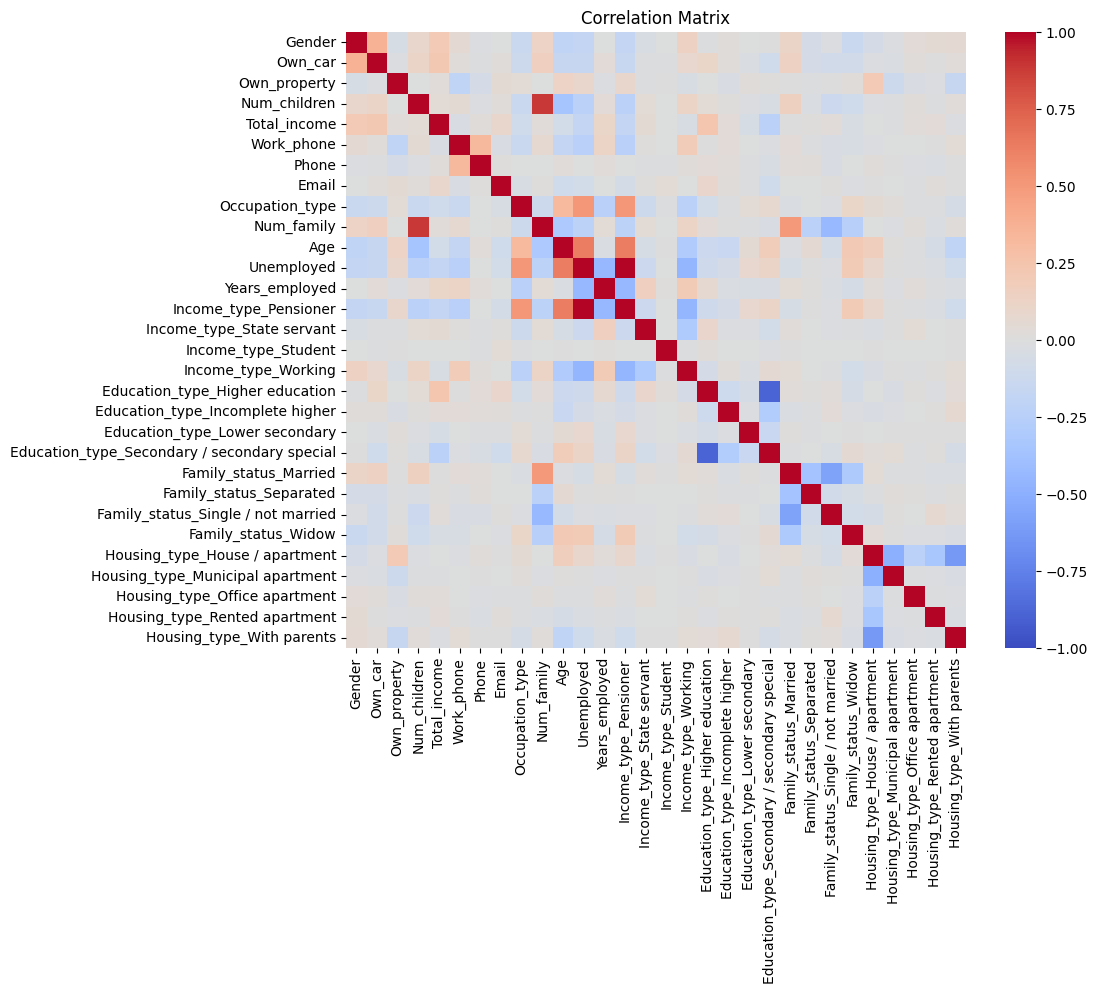

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = X_balance.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [26]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
X_train, X_test, y_train, y_test = train_test_split(X_balance, y_balance, test_size=0.2, random_state=42)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

                                         Feature  Importance
10                                           Age    0.247478
4                                   Total_income    0.194168
12                                Years_employed    0.160438
8                                Occupation_type    0.081053
9                                     Num_family    0.030846
1                                        Own_car    0.027601
2                                   Own_property    0.026587
6                                          Phone    0.026539
0                                         Gender    0.026134
3                                   Num_children    0.022449
5                                     Work_phone    0.018532
16                           Income_type_Working    0.017399
21                         Family_status_Married    0.015648
20  Education_type_Secondary / secondary special    0.011779
7                                          Email    0.011776
25                Housin

#Removing the features that are not important
#Then applying logistic regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
threshold = 0.001
important_features = feature_importances[feature_importances['Importance'] >= threshold]['Feature']
print("Selected Features:", important_features.tolist())
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]
logr = LogisticRegression(max_iter=1000, random_state=42)
logr.fit(X_train_reduced, y_train)
y_pred = logr.predict(X_test_reduced)
print("Accuracy with reduced features:", accuracy_score(y_test, y_pred))


Selected Features: ['Age', 'Total_income', 'Years_employed', 'Occupation_type', 'Num_family', 'Own_car', 'Own_property', 'Phone', 'Gender', 'Num_children', 'Work_phone', 'Income_type_Working', 'Family_status_Married', 'Education_type_Secondary / secondary special', 'Email', 'Housing_type_House / apartment', 'Education_type_Higher education', 'Income_type_State servant', 'Family_status_Single / not married', 'Family_status_Separated', 'Housing_type_With parents', 'Housing_type_Municipal apartment', 'Education_type_Incomplete higher', 'Family_status_Widow', 'Housing_type_Rented apartment', 'Education_type_Lower secondary', 'Income_type_Pensioner', 'Unemployed', 'Housing_type_Office apartment']
Accuracy with reduced features: 0.5442899702085402


# Logistic regression with hyperparameter tuning

In [28]:
logr = LogisticRegression()
grid_params = {
    'C': [3, 5],
    'max_iter': [2000],
    'solver': ['lbfgs', 'saga']
}

grid = GridSearchCV(estimator=logr, param_grid=grid_params, cv=4, scoring='accuracy', verbose=1)
grid.fit(X_train_reduced, y_train)
model_logr = grid.best_estimator_
print("Best Parameters for Logistic Regression:", grid.best_params_)
y_pred = model_logr.predict(X_test_reduced)
y_proba = model_logr.predict_proba(X_test_reduced)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best Parameters for Logistic Regression: {'C': 3, 'max_iter': 2000, 'solver': 'lbfgs'}
Logistic Regression Accuracy: 0.5450
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.52      0.53      4975
           1       0.55      0.57      0.56      5095

    accuracy                           0.54     10070
   macro avg       0.54      0.54      0.54     10070
weighted avg       0.54      0.54      0.54     10070

Logistic Regression Confusion Matrix:
[[2585 2390]
 [2192 2903]]


In [29]:
Final_Accuracy_Logistic_Regression = accuracy

# Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_reduced, y_train)

y_pred_rf = rf_model.predict(X_test_reduced)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
Final_Accuracy_rf = accuracy


Random Forest Accuracy: 0.7809
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      4975
           1       0.79      0.78      0.78      5095

    accuracy                           0.78     10070
   macro avg       0.78      0.78      0.78     10070
weighted avg       0.78      0.78      0.78     10070

Random Forest Confusion Matrix:
[[3901 1074]
 [1132 3963]]


In [31]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
svm_model = SVC(random_state=42, class_weight='balanced')
svm_model.fit(X_train_reduced, y_train)

y_pred_svm = svm_model.predict(X_test_reduced)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


SVM Accuracy: 0.5513406156901688
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.59      0.56      4975
           1       0.56      0.52      0.54      5095

    accuracy                           0.55     10070
   macro avg       0.55      0.55      0.55     10070
weighted avg       0.55      0.55      0.55     10070

SVM Confusion Matrix:
[[2919 2056]
 [2462 2633]]


In [32]:
Final_Accuracy_SVM = accuracy_svm


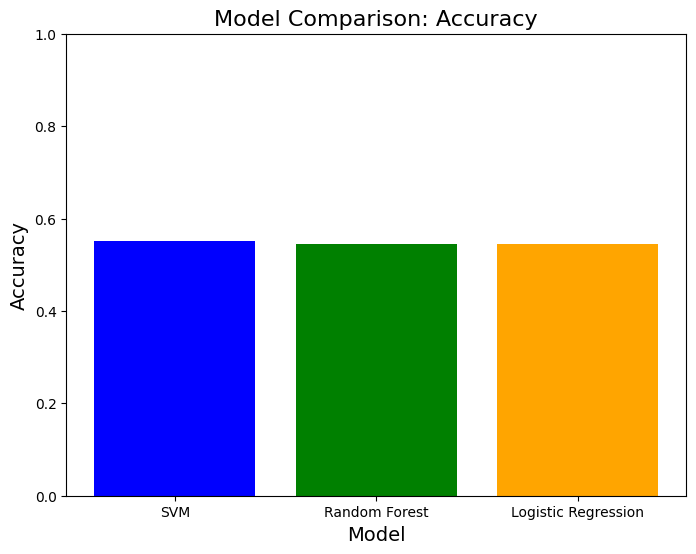

In [33]:
import matplotlib.pyplot as plt

# Models to plot
models = ['SVM', 'Random Forest', 'Logistic Regression']
accuracies = [Final_Accuracy_SVM, Final_Accuracy_rf, Final_Accuracy_Logistic_Regression]

# Create the plot
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])

# Add titles and labels
plt.title('Model Comparison: Accuracy', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim([0, 1])  # Accuracy is between 0 and 1

# Display the plot
plt.show()

# **Final analysis**
In this dataset the data seems to be more biased to bad if we use a specific criteria for labeling each customer, this will give a minority for the bad and majority for good and the accuracy will be a very good number, but the number will not be true in terms of making sense, as it will not predict bad values and only assign to good values, so this is not right.
so in my case, I assigned a different criteria to make the data less biased then used SMOTE technique to make it oversampled to balance the data to work on it.
Given the final plot, random forst is the best model for our dataset as it gives the best accuracy.